In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from scipy.optimize import curve_fit
from typing import Iterable
from html.parser import HTMLParser

In [2]:
req = urllib.request.Request('https://www.coronatracker.at/wien', headers={
    'User-Agent': 'Mozilla/5.0 (go) fuck (a) blender'
})

txtdata = urllib.request.urlopen(req).read().decode()
# print(txtdata, end="\n\n")

In [3]:
tabledata = list()

class MyHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.my_table_active = False
        self.my_fieldcnt = 0
        self.my_fields = None
        
    def handle_starttag(self, tag, attrs):
        if tag == "table":
            self.my_table_active = True
            self.my_fieldcnt = 0
        if self.my_table_active:
            # print("Encountered a start tag:", tag, attrs)
            if tag == 'tr':
                self.my_fieldcnt = 0
                self.my_fields = list()
            if tag == 'td':
                self.my_fieldcnt += 1

    def handle_endtag(self, tag):
        if self.my_table_active:
            # print("Encountered an end tag :", tag)
            if tag == 'tr' and len(self.my_fields):
                # print(self.my_fields)
                tabledata.append(self.my_fields)
        if tag == "table":
            self.my_table_active = False

    def handle_data(self, data):
        if self.my_table_active:
            # print("Encountered some data  :", data, self.my_fieldcnt)
            if self.my_fieldcnt and len(self.my_fields) < self.my_fieldcnt:
                self.my_fields.append(data)

parser = MyHTMLParser()
parser.feed(txtdata)

dates = [".".join(d[0].split(".")[0:2]) for d in reversed(tabledata)]
print(dates)

data = [int(d[2].replace(".", "")) for d in reversed(tabledata)]
print(data)

['24.02', '25.02', '26.02', '27.02', '28.02', '29.02', '01.03', '02.03', '03.03', '04.03', '05.03', '06.03', '07.03', '08.03', '09.03', '10.03', '11.03', '12.03', '13.03', '14.03', '15.03', '16.03', '17.03', '18.03', '19.03', '20.03', '21.03', '22.03', '23.03', '24.03', '25.03', '26.03', '27.03', '28.03', '29.03', '30.03', '31.03', '01.04', '02.04', '03.04', '04.04', '05.04', '06.04', '07.04', '08.04', '09.04', '10.04', '11.04', '12.04', '13.04', '14.04', '15.04', '16.04', '17.04', '18.04', '19.04', '20.04', '21.04', '22.04', '23.04', '24.04', '25.04', '26.04', '27.04', '28.04', '29.04', '30.04', '01.05', '02.05', '03.05', '04.05', '05.05', '06.05', '07.05', '08.05', '09.05', '10.05', '11.05', '12.05', '13.05', '14.05', '15.05', '16.05', '17.05', '18.05', '19.05', '20.05', '21.05', '22.05', '23.05', '24.05', '25.05', '26.05', '27.05', '28.05', '29.05', '30.05', '31.05', '01.06', '02.06', '03.06', '04.06', '05.06', '06.06', '07.06', '08.06', '09.06', '10.06', '11.06', '12.06', '13.06', 

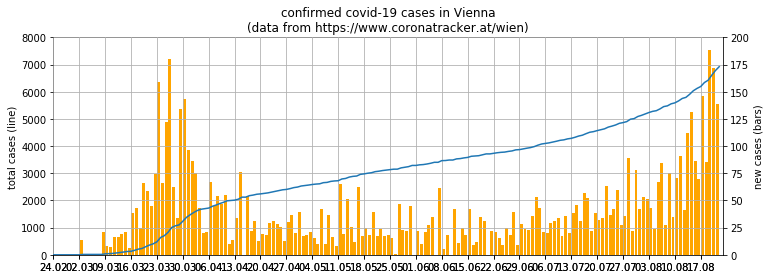

In [4]:
fig = plt.figure(figsize=(12,4))
fig.patch.set_facecolor('white')

ax2 = fig.add_subplot(111)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.ylabel("new cases (bars)")
plt.bar(np.arange(len(data)-1)+0.5, np.diff(data), color='orange')
plt.ylim(0, 200)

xt = np.arange(0, len(dates), 7)
plt.xticks(xt, [dates[i] for i in xt])

ax1 = fig.add_subplot(111, sharex=ax2, frameon=False)
plt.ylabel("total cases (line)")
plt.plot(data)
plt.ylim(0, 8000)

plt.title("confirmed covid-19 cases in Vienna\n"
          "(data from https://www.coronatracker.at/wien)")
plt.xlim(0, len(data))
plt.grid()

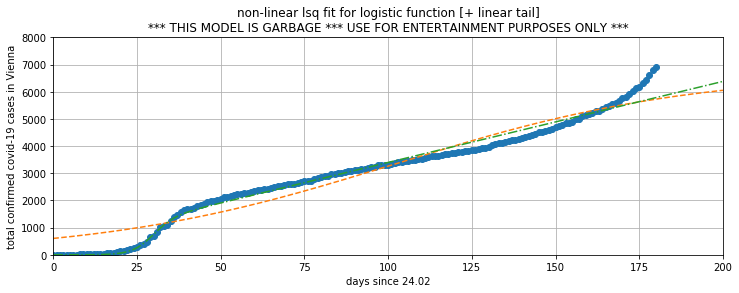

In [5]:
def expit(x):
    return 1/(1+np.exp(-x))

def intexpit(x):
    return np.log(np.exp(x)+1)

def f1(x, xs, xo, ys):
    return f2(x, xs, xo, ys, 0)

def f2(x, xs, xo, ys, k):
    if isinstance(x, Iterable):
        return [f2(v, xs, xo, ys, k) for v in x]
    else:
        y = ys*expit(xs*x+xo)
        y += k*intexpit(xs*x+xo)
        return y

p1_0 = [0.22, -7.0, 14000.0]
p2_0 = [0.26, -7.7, 10000.0, 640.0]

xd = np.arange(len(data))
yd = data

p1, pcov1 = curve_fit(f1, xd, yd, p1_0)
#print(p1)
#print(pcov1)

p2, pcov2 = curve_fit(f2, xd, yd, p2_0)
#print(p2)
#print(pcov2)

fig = plt.figure(figsize=(12,4))
fig.patch.set_facecolor('white')

plt.title("non-linear lsq fit for logistic function [+ linear tail]\n" +
          "*** THIS MODEL IS GARBAGE *** USE FOR ENTERTAINMENT PURPOSES ONLY ***")
plt.ylabel("total confirmed covid-19 cases in Vienna")
plt.xlabel("days since %s" % dates[0])
plt.plot(data, "o")
plt.plot(np.arange(0, 201), f1(np.arange(0, 201), *p1), "--")
plt.plot(np.arange(0, 201), f2(np.arange(0, 201), *p2), "-.")
plt.ylim(0, 8000)
plt.xlim(0, 200)
plt.grid()